# Importing Files

In [33]:
import tensorflow as tf
from tensorflow import keras
import os
import zipfile
import urllib
import PIL
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


# Getting data from source and extracting files

In [2]:
urllib.request.urlretrieve("https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip",
                           filename="validation-horse-or-human.zip")
zip_ref = zipfile.ZipFile("validation-horse-or-human.zip", 'r')
zip_ref.extractall("validation-horse-or-human")
zip_ref.close()

# Setting path for dataset

In [35]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('validation-horse-or-human/humans')

#Directory for local test_data
test_local_dir = os.path.join('test_local_data')

# Printing name of fies in dataset

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']
['horse1-000.png', 'horse1-105.png', 'horse1-122.png', 'horse1-127.png', 'horse1-170.png', 'horse1-204.png', 'horse1-224.png', 'horse1-241.png', 'horse1-264.png', 'horse1-276.png']
['valhuman01-00.png', 'valhuman01-01.png', 'valhuman01-02.png', 'valhuman01-03.png', 'valhuman01-04.png', 'valhuman01-05.png', 'valhuman01-06.png', 'valhuman01-07.png', 'valhuman01-08.png', 'valhuman01-09.png']


# Plotting dataset

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

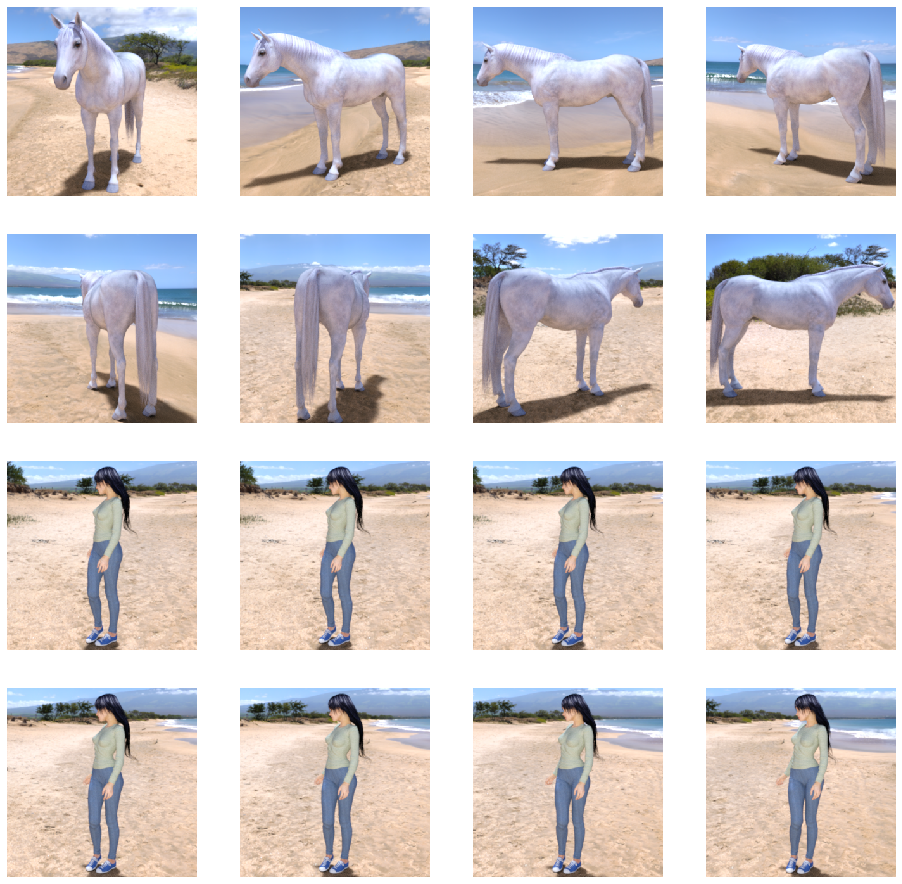

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


# Creating Model 

In [28]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 64)       

In [30]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [31]:
class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        #print("\nEnd epoch {} of training; got log keys: {}\n".format(epoch, keys))
        #print(logs["accuracy"])
        if(logs["val_accuracy"]>0.85):
            print("\nAccuracy level reached\n")
            self.model.stop_training = True

In [32]:
history = model.fit(
      train_generator,
      epochs=5,
      verbose=1,
      validation_data = validation_generator,
      callbacks = [CustomCallback()]
      )

Train for 17 steps, validate for 16 steps
Epoch 1/5
17/17 [==============================] - 15s 904ms/step - loss: 0.8621 - accuracy: 0.5833 - val_loss: 0.8181 - val_accuracy: 0.6445
Epoch 2/5
17/17 [==============================] - 14s 819ms/step - loss: 0.3254 - accuracy: 0.8793 - val_loss: 0.5293 - val_accuracy: 0.8438
Epoch 3/5
16/17 [===========================>..] - ETA: 0s - loss: 0.1859 - accuracy: 0.9252
Accuracy level reached

17/17 [==============================] - 14s 829ms/step - loss: 0.1786 - accuracy: 0.9279 - val_loss: 0.8351 - val_accuracy: 0.8750


[0.]
test_img.jpg is a horse
[0.]
test_img2.jpg is a horse
[1.]
test_img3.png is a human
[1.]
test_img4.jpg is a human
[0.]
test_img5.jpg is a horse
[1.]
test_img6.jpg is a human
[0.]
test_img7.jpg is a horse
[1.]
test_img8.jpg is a human
[0.]
test_img9.jpg is a horse


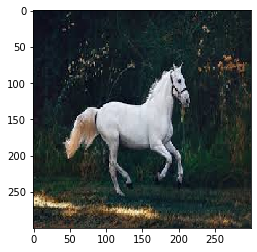

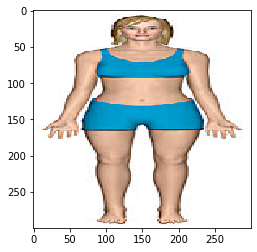

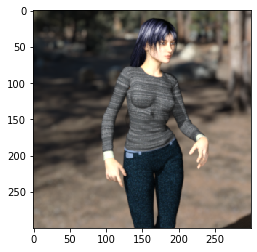

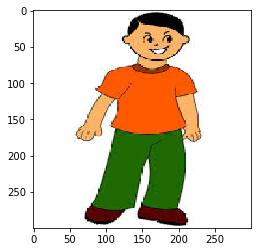

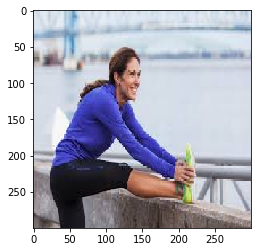

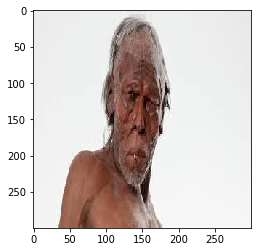

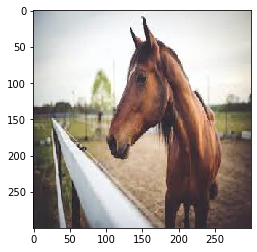

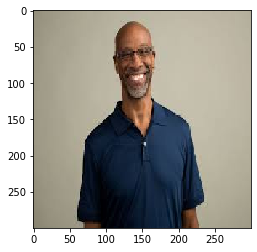

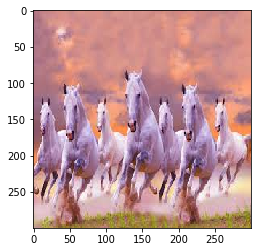

In [48]:
test_local_data = os.listdir(test_local_dir)

for fn in test_local_data:
 
  # predicting images
    path = 'test_local_data/' + fn
    img = image.load_img(path, target_size=(300, 300))
    plt.figure()
    plt.imshow(np.asarray(img))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

C:\Users\DK\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


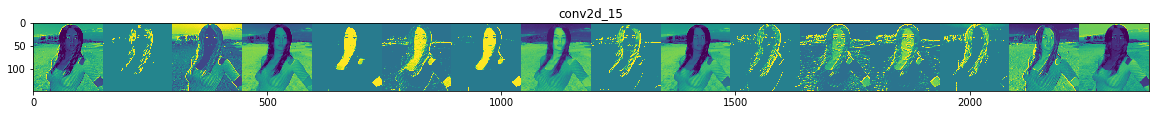

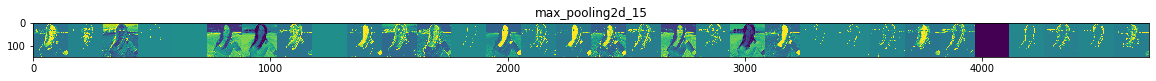

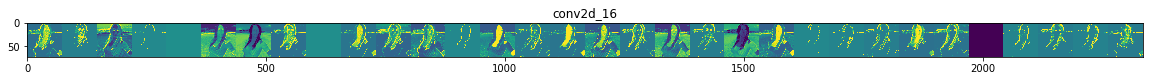

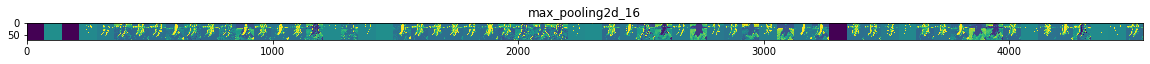

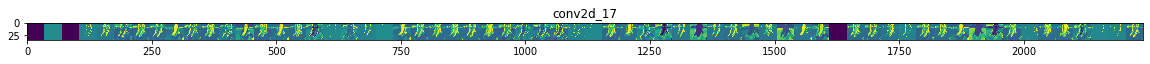

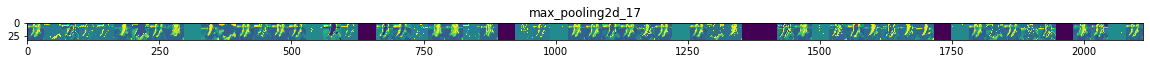

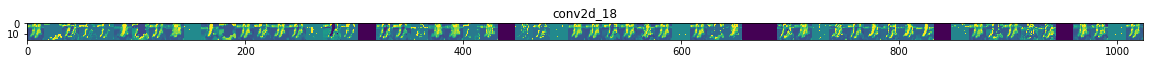

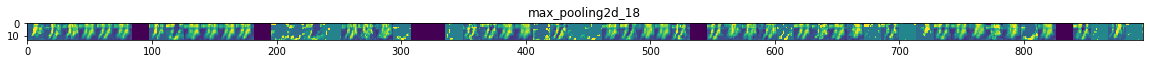

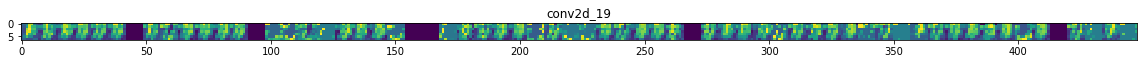

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
      if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
          # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

# For images of size 150x150

In [57]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [58]:
model.summary()
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18496)            

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 300x300
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 300x300
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [59]:
history = model.fit(
      train_generator,
      epochs=5,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks = [CustomCallback()]
      )

Train for 8 steps, validate for 8 steps
Epoch 1/5
8/8 [==============================] - 9s 1s/step - loss: 1.8371 - accuracy: 0.5215 - val_loss: 0.6014 - val_accuracy: 0.6250
Epoch 2/5
8/8 [==============================] - 7s 860ms/step - loss: 0.7630 - accuracy: 0.7361 - val_loss: 0.7137 - val_accuracy: 0.6641
Epoch 3/5
8/8 [==============================] - 6s 786ms/step - loss: 0.3810 - accuracy: 0.8555 - val_loss: 1.5161 - val_accuracy: 0.7031
Epoch 4/5
8/8 [==============================] - 6s 777ms/step - loss: 0.2878 - accuracy: 0.8647 - val_loss: 1.8171 - val_accuracy: 0.6719
Epoch 5/5
8/8 [==============================] - 7s 911ms/step - loss: 0.1211 - accuracy: 0.9490 - val_loss: 1.7124 - val_accuracy: 0.7578


[0.]
test_img.jpg is a horse
[1.]
test_img2.jpg is a human
[1.]
test_img3.png is a human
[1.]
test_img4.jpg is a human
[0.]
test_img5.jpg is a horse
[1.]
test_img6.jpg is a human
[0.]
test_img7.jpg is a horse
[1.]
test_img8.jpg is a human
[0.]
test_img9.jpg is a horse


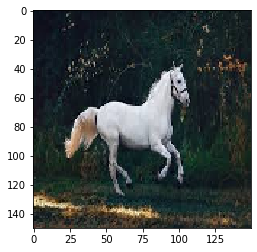

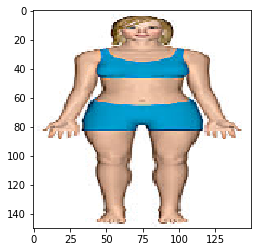

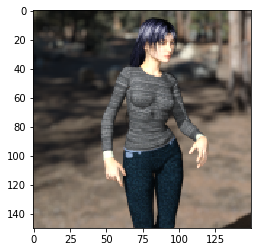

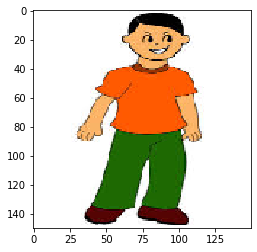

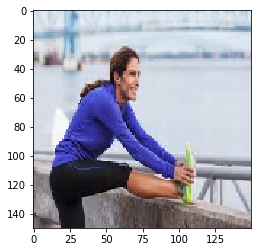

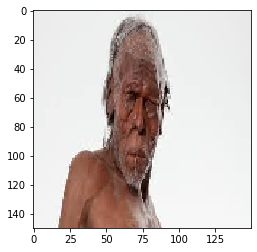

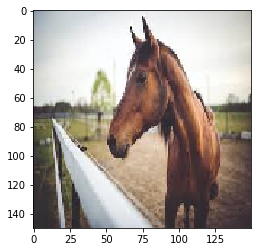

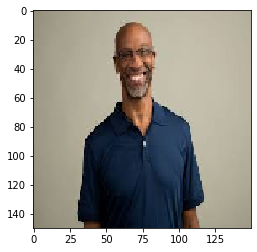

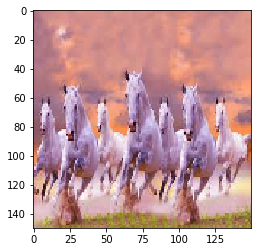

In [60]:
test_local_data = os.listdir(test_local_dir)

for fn in test_local_data:
 
  # predicting images
    path = 'test_local_data/' + fn
    img = image.load_img(path, target_size=(150, 150))
    plt.figure()
    plt.imshow(np.asarray(img))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")